# Fitbit sleep duration analysis
Created by Luke Kippenbrock and last edited on 11 Oct 2019

Look for correlations between fitbit sleep duration and other fitbit parameters


## Import modules

In [1]:
from collections import Counter, defaultdict
import csv
import datetime
import json
import math
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
from scipy import stats
import statistics
from typing import Any, Dict, List, NamedTuple 

## Create classes for storing data

In [2]:
#Class for Fitbit sleep event
class SleepEvent(NamedTuple):
    log_id: int
    total_hours: float
    start_time: datetime.datetime
    stop_time: datetime.datetime

#Class for day weather
class DayWeather(NamedTuple):
    date: datetime.date
    temp_max: float
    temp_min: float

#Class for Day
class Day(NamedTuple):
    date: datetime.date
    total_hours: float
    temp_max: float
    temp_min: float

In [3]:
fitbit_directory_name = "LukeKippenbrock/user-site-export"
fitbit_directory = os.fsencode(fitbit_directory_name)

## Get raw activity data from Fitbit directory
If the data has not preveiously been saved to file (in a dict), then get the data and also save the data to file.  If data has already been saved to file, then load the data from file.
Data is saved in a dictionary, with the key being the date in string format.

In [4]:
def process_fitbit_data(log_name: str) -> Dict[str, float]:
    if os.path.exists(f"Processed_Data/{log_name}.json"):
        with open(f"Processed_Data/{log_name}.json","r") as json_file:
            dict = json.load(json_file)
            value_dict = defaultdict(float,dict)
    else:
        value_dict: Dict[str, float] = defaultdict(float)
        for file in os.listdir(fitbit_directory):
            filename = os.fsdecode(file)
            if log_name in filename:
                filename_with_directory = f"{fitbit_directory_name}/{filename}"
                with open(filename_with_directory,"r") as f:
                    data = f.read()
                    obj = json.loads(data)
                    for value_event in obj:
                        value = float(value_event["value"]) #get value for each value_event
                        string_dt = value_event["dateTime"] #get datetime for each value_event
                        dt = datetime.datetime.strptime(string_dt,'%m/%d/%y %H:%M:%S') #Convert to datetime format
                        #Steps and distance in file are dated according to GMT, which is 7 hours ahead of Seattle, so a shift is necessary
                        if log_name=="steps":
                            dt += datetime.timedelta(hours=-7)
                        if log_name=="distance":
                            dt += datetime.timedelta(hours=-7)
                        string_date = dt.strftime('%Y-%m-%d')
                        value_dict[string_date] += value
        #Save data to file
        json_dict = json.dumps(value_dict)
        with open(f"Processed_Data/{log_name}.json","w") as f:
            f.write(json_dict)
            f.close()
    return value_dict

In [5]:
steps_dict: Dict[str, float] = process_fitbit_data("steps")
distance_dict: Dict[str, float] = process_fitbit_data("distance")
calories_dict: Dict[str, float] = process_fitbit_data("calories")
stairs_dict: Dict[str, float] = process_fitbit_data("altitude")

lightly_active_dict: Dict[str, float] = process_fitbit_data("lightly_active")
moderately_active_dict: Dict[str, float] = process_fitbit_data("moderately_active")
very_active_dict: Dict[str, float] = process_fitbit_data("very_active")
sedentary_dict: Dict[str, float] = process_fitbit_data("sedentary")

## Get raw heart rate data from fitbit directory
The heart rate data has a different format than the other fitbit activity data and so needs separate processing

In [6]:
def process_heart_rate_data(zone_name: str) -> Dict[str, float]:
    value_dict: Dict[str, float] = defaultdict(float)
    for file in os.listdir(fitbit_directory):
        filename = os.fsdecode(file)
        log_name = "time_in_heart_rate_zones"
        if log_name in filename:
            filename_with_directory = f"{fitbit_directory_name}/{filename}"
            with open(filename_with_directory,"r") as f:
                data = f.read()
                obj = json.loads(data)
                for value_event in obj:
                    value = float(value_event["value"]["valuesInZones"][zone_name]) #get value for each value_event
                    string_dt = value_event["dateTime"] #get datetime for each value_event
                    dt = datetime.datetime.strptime(string_dt,'%m/%d/%y %H:%M:%S') #Convert to datetime format
                    d = dt.strftime('%Y-%m-%d') 
                    value_dict[d] += value
    #Save data to file
    json_dict = json.dumps(value_dict)
    with open(f"Processed_Data/{zone_name}.json","w") as f:
        f.write(json_dict)
        f.close()
    return value_dict

In [7]:
heart_below_one_dict: Dict[str, float] = process_heart_rate_data("BELOW_DEFAULT_ZONE_1")
heart_zone_one_dict: Dict[str, float] = process_heart_rate_data("IN_DEFAULT_ZONE_1")
heart_zone_two_dict: Dict[str, float] = process_heart_rate_data("IN_DEFAULT_ZONE_2")
heart_zone_three_dict: Dict[str, float] = process_heart_rate_data("IN_DEFAULT_ZONE_3")

## Get raw sleep data from Fitbit directory
Data for each sleep event is saved to a raw sleep list, which needs further processing.

In [8]:
raw_sleep_list = []
for file in os.listdir(fitbit_directory):
     filename = os.fsdecode(file)
     if "sleep" in filename:
        filename_with_directory = f"{fitbit_directory_name}/{filename}"
        with open(filename_with_directory,"r") as f:
            data = f.read()
            obj = json.loads(data)
            for sleep_event in obj:
                #if (sleep_event["type"] != "stages"): continue
                total_hours = sleep_event["minutesAsleep"]/60 #Get hours asleep
                #if 'levels' in sleep_event:
                #if 'summary' in sleep_event["levels"]:
                #if 'deep' in sleep_event["levels"]["summary"]:
                #total_hours = sleep_event["levels"]["summary"]["deep"]["minutes"]/60 #Get hours asleep
                string_start_time = sleep_event["startTime"] #Get date in string format
                string_stop_time = sleep_event["endTime"] #Get date in string format
                start_time = datetime.datetime.strptime(string_start_time,'%Y-%m-%dT%H:%M:%S.000') #Convert to datetime format
                stop_time = datetime.datetime.strptime(string_stop_time,'%Y-%m-%dT%H:%M:%S.000') #Convert to datetime format
                log_id = sleep_event["logId"] #Get log id
                sleep_event = SleepEvent(log_id, total_hours, start_time, stop_time)
                raw_sleep_list.append(sleep_event)

raw_sleep_list.sort()

## Process sleep data

Several things are done in this code:
- Exclude sleep events that occur when I'm not in Seattle
- Remove any duplicate sleep events (which occur at beginning/end of fitbit files)
- Remove naps (events which start between noon and 8pm and which end before 8pm)
- Combine sleep events that occur during the same night

In [9]:
date_list = []
sleep_list = []
sleep_dict = defaultdict(float)
start_time_list = []
stop_time_list = []
sleep_segment_list = []
previous_date = datetime.date(2000, 8, 30)  #random date in the far past

#Exclude dates when I was not in Seattle
#travel_dates is a list of dates in the format
#travel_dates = [[datetime.date(2016, 12, 20), datetime.date(2017, 1, 4)],...
from vacation_dates import travel_dates

#Compare event log id so as to exclude duplicate events
previous_log_id = 0

#Record all sleep events on the same date (for plotting purposes)
default_datetime = datetime.datetime(2000, 1, 1, 0, 0, 0);

for event in raw_sleep_list:
    #Get start hour of sleep event
    start_hour = event.start_time.hour
    #Shift date to prior day for start times after midnight til 11am
    if start_hour<11:
        date = event.start_time.date() - datetime.timedelta(days=1)
        shift = datetime.timedelta(hours=0)
    #But don't shift date when sleep starts after 11am and before midnight
    else:
        date = event.start_time.date()
        shift = datetime.timedelta(hours=-24)
    seattle_date = True
    #Exlude days when not in Seattle
    for date_range in travel_dates:
        start_date, stop_date = date_range
        if start_date <= date <= stop_date:
            seattle_date = False
            break
    if seattle_date:
        start = event.start_time
        stop = event.stop_time
        date_string = date.strftime('%Y-%m-%d')
        #Remove any duplicate sleep logs (at beginning/end of files)
        if previous_log_id==event.log_id:
            continue
        #Remove naps
        elif 12<=start.hour<20 and stop.hour<20:
            continue
        #Combine sleep records for events with same dates
        elif previous_date==date:
            sleep_segment_list[-1] += 1 
            sleep_list[-1] += event.total_hours
            stop_timedelta = datetime.timedelta(hours=stop.hour,minutes=stop.minute,seconds=stop.second)
            stop_time_list[-1] = default_datetime + stop_timedelta
            sleep_dict[date_string] += event.total_hours
        #Save sleep record
        else:
            sleep_segment_list.append(1)
            date_list.append(date)
            sleep_list.append(event.total_hours)
            sleep_dict[date_string] = event.total_hours
            start_timedelta = datetime.timedelta(hours=start.hour,minutes=start.minute,seconds=start.second)
            start_time_list.append(default_datetime + start_timedelta + shift)
            stop_timedelta = datetime.timedelta(hours=stop.hour,minutes=stop.minute,seconds=stop.second)
            stop_time_list.append(default_datetime + stop_timedelta)
        previous_date = date
        previous_log_id = event.log_id

In [10]:
heart_below_one_list = []
heart_zone_one_list = []
heart_zone_two_list = []
heart_zone_three_list = []

lightly_active_list = []
moderately_active_list = []
very_active_list = []
sedentary_list = []

stairs_list = []
steps_list = []
calories_list = []
distance_list = []
previous_day_sleep_list = []
current_day_sleep_list = []
weekday_list = []
month_list = []
for d in date_list:
    string_date = d.strftime('%Y-%m-%d')
    
    #Heart below 1 hours
    heart_below_one_hours = heart_below_one_dict[string_date]/60 #Convert from minutes to hours
    heart_below_one_list.append(heart_below_one_hours)
    #Heart zone 1 hours
    heart_zone_one_hours = heart_zone_one_dict[string_date]/60 #Convert from minutes to hours
    heart_zone_one_list.append(heart_zone_one_hours)
    #Heart zone 2 minutes
    heart_zone_two_minutes = heart_zone_two_dict[string_date]
    heart_zone_two_list.append(heart_zone_two_minutes)
    #Heart zone 3 minutes
    heart_zone_three_minutes = heart_zone_three_dict[string_date]
    heart_zone_three_list.append(heart_zone_three_minutes)
    
    #Lightly active hours
    lightly_active_hours = lightly_active_dict[string_date]/60 #Convert from minutes to hours
    lightly_active_list.append(lightly_active_hours)
    #Moderately active hours
    moderately_active_hours = moderately_active_dict[string_date]/60 #Convert from minutes to hours
    moderately_active_list.append(moderately_active_hours)
    #Very active hours
    very_active_hours = very_active_dict[string_date]/60 #Convert from minutes to hours
    very_active_list.append(very_active_hours)
    #Sedentary hours
    sedentary_hours = sedentary_dict[string_date]/60 #Convert from minutes to hours
    sedentary_list.append(sedentary_hours)
    
    #Stairs
    stairs = stairs_dict[string_date]/10 #Convert from stairs to floors (1 floor = 10 stairs)
    stairs_list.append(stairs)
    #Steps
    steps = steps_dict[string_date]
    steps_list.append(steps)
    #Calories
    calories = calories_dict[string_date]
    calories_list.append(calories)
    #Distance
    distance = distance_dict[string_date]
    miles = distance*6.21371e-6  #Convert from centimeters to miles
    distance_list.append(miles)
    
    #Previous day's sleep
    previous_date = d - datetime.timedelta(days=1)
    previous_date_string = previous_date.strftime('%Y-%m-%d')
    previous_day_sleep = sleep_dict[previous_date_string]
    current_date_string = d.strftime('%Y-%m-%d')
    current_day_sleep = sleep_dict[current_date_string]
    if previous_day_sleep: #Remove days with no sleep record for previous day
        previous_day_sleep_list.append(previous_day_sleep)
        current_day_sleep_list.append(current_day_sleep)
        
    #Weekday
    weekday = d.weekday()
    weekday_list.append(weekday)
    #Month
    month = d.month
    month_list.append(month)

## Plot sleep duration as a function of time

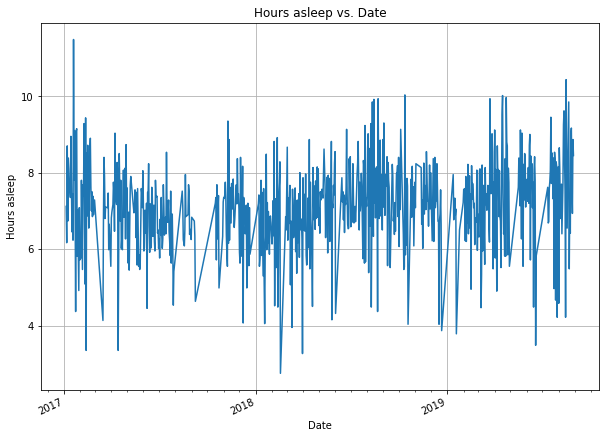

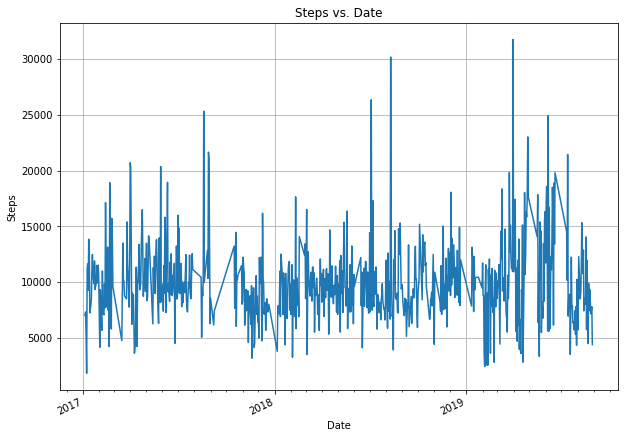

In [11]:
#Adjust default figure plotting size
plt.rcParams["figure.figsize"] = (10,7.5)

def plot_time(list_date: List[datetime.datetime], list_other: List[Any], label: str):
    plt.plot(list_date, list_other)
    ax = plt.gcf().axes[0]
    formatter = dates.DateFormatter('%Y-%m')
    #Make the time axis have major ticks for every year and minor ticks for every month
    years = dates.YearLocator()   # every year
    months = dates.MonthLocator()  # every month
    years_fmt = dates.DateFormatter('%Y') #Label only the major ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    ax.grid(True)
    plt.gcf().autofmt_xdate(rotation=25)
    plt.title(f"{label} vs. Date")
    plt.xlabel("Date")
    plt.ylabel(f"{label}")
    plt.show()
    plt.gca().clear()
    plt.close()

plot_time(date_list, sleep_list, "Hours asleep")
plot_time(date_list, steps_list, "Steps")

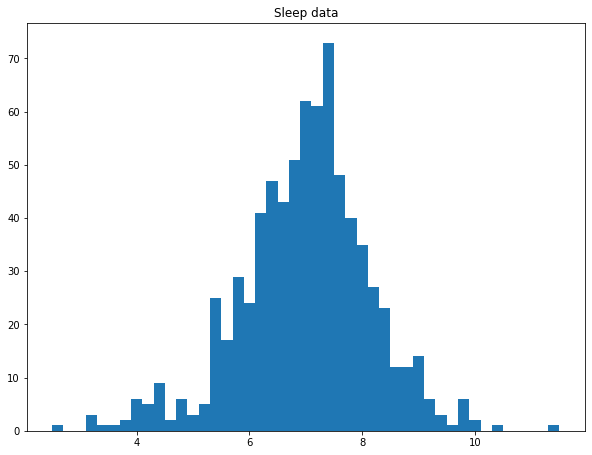

In [12]:
#Functions taken from "Data Science from Scratch", second edition, by Joel Grus
def bucketize(point: float, bucket_size: float) -> float:
    """Floor the point to the next lower multiple of bucket_size"""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points: List[float], bucket_size: float) -> Dict[float, int]:
    """Buckets the points and counts how many in each bucket"""
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points: List[float], bucket_size: float, title: str = ""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()
    plt.close()
    
plot_histogram(sleep_list,0.2,"Sleep data")

In [13]:
def plot_variable_histogram(sleep_list: List[float], variable_list: List[float], setting: str):
    mean_list = []
    stdev_list = []
    start = 0
    stop = 7
    if setting=="month":
        start = 1
        stop = 13
    for x in range(start,stop):
        variable_sleep_list = []
        for sleep, variable in zip(sleep_list, variable_list):
            if variable==x:
                variable_sleep_list.append(sleep)
        #print(f"{x} {variable_sleep_list}")
        mean = statistics.mean(variable_sleep_list)
        mean_list.append(mean)
        stdev = statistics.stdev(variable_sleep_list)
        stdev_list.append(stdev)
    #plot_histogram(variable_sleep_list,0.5,f"Day = {x}")
    #Plot sleep duration by weekday (See Ref #2)
    if setting=="weekday":
        N = 7
        ind = np.arange(N)    # the x locations for the groups
        width = 0.50       # the width of the bars: can also be len(x) sequence
        p1 = plt.bar(ind, mean_list, width, yerr=stdev_list)
        plt.ylabel('Sleep duration (hours)')
        plt.title('Sleep duration by day of the week')
        plt.xticks(ind, ('Mon', 'Tues', 'Wed', 'Thurs', 'Fri','Sat','Sun'))
        plt.show()
        plt.close()
    elif setting=="month":
        N = 12
        ind = np.arange(N)    # the x locations for the groups
        width = 0.50       # the width of the bars: can also be len(x) sequence
        p1 = plt.bar(ind, mean_list, width, yerr=stdev_list)
        plt.ylabel('Sleep duration (hours)')
        plt.title('Sleep duration by month')
        plt.xticks(ind, ('Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
        plt.show()
        plt.close()

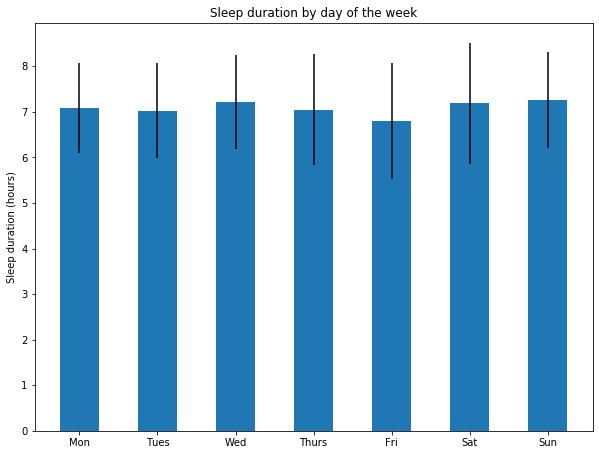

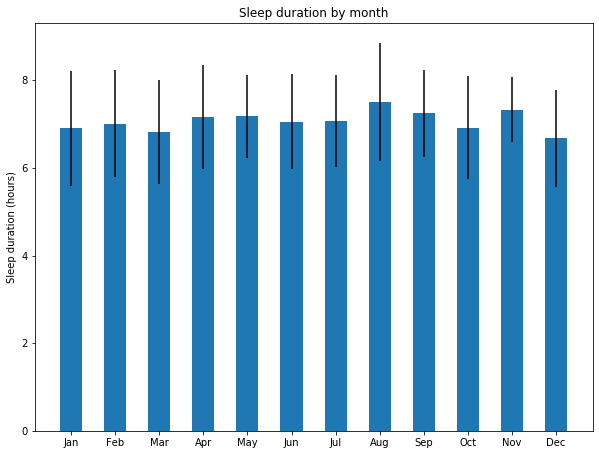

In [14]:
plot_variable_histogram(sleep_list, weekday_list, "weekday")
plot_variable_histogram(sleep_list, month_list, "month")

## Get Seattle weather data
Record the min and max temperature

In [15]:
weather_list = []
with open('SeattleWeather.csv') as f:
    comma_reader = csv.reader(f, delimiter=',')
    next(comma_reader) #skip the first row of the file (header row)
    for row in comma_reader:
        string_date = row[2]
        converted_date = datetime.datetime.strptime(string_date, '%Y-%m-%d').date()
        temp_max = float(row[4])
        temp_min = float(row[5])
        day_weather = DayWeather(converted_date, temp_max, temp_min)
        weather_list.append(day_weather)

temp_max_list = []
temp_min_list = []
for date in date_list:
    for day in weather_list:
        if date == day.date:
            temp_max_list.append(day.temp_max)
            temp_min_list.append(day.temp_min)

## Plot sleep duration as a function of other parameters
Look for correlations between sleep duration and the parameters

In [16]:
def plot_nice(list1: List[Any], list2: List[Any], title: str, label1: str, label2: str):
    plt.plot(list1, list2, 'o', alpha=0.2, label='data')
    # label each point
    '''for x, y, date in zip(list1, list2, date_list):
        plt.annotate(date,
                 xy=(x, y), # Put the label with its point
                 xytext=(5, -5),                  # but slightly offset
                 textcoords='offset points',
                 size=5)'''
    plt.title(title)
    plt.xlabel(label1)
    plt.ylabel(label2)
    
    x = np.asarray(list1)
    y = np.asarray(list2)

    if isinstance(list1[0],datetime.datetime): #For time on x-axis (see Ref #1)
        x = dates.date2num(list1)
        plt.gcf().autofmt_xdate()
        myFmt = dates.DateFormatter('%H:%M')
        plt.gca().xaxis.set_major_formatter(myFmt)
    if isinstance(list2[0],datetime.datetime): #For time on y-axis
        y = dates.date2num(list2)
        myFmt = dates.DateFormatter('%H:%M')
        plt.gca().yaxis.set_major_formatter(myFmt)

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    #print("slope: %f    intercept: %f" % (slope, intercept))
    print(f"R-squared: {r_value**2} for {title}")
    plt.plot(x, intercept + slope*x, 'r', label='linear fit')
    plt.legend()
    
    ax = plt.gcf().axes[0]
    ax.grid(True)
    #if (r_value**2 >0.05):
    plt.show()
    plt.gca().clear()
    plt.close()

R-squared: 0.0002940887573508786 for Sleep duration vs. Time below heart zone 1


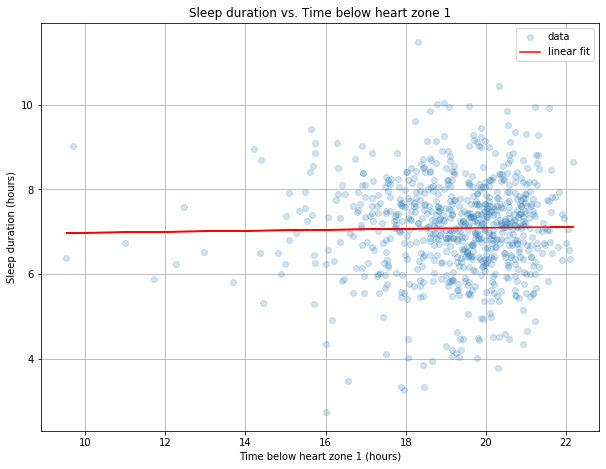

R-squared: 0.00015233601036812003 for Sleep duration vs. Time in heart zone 1


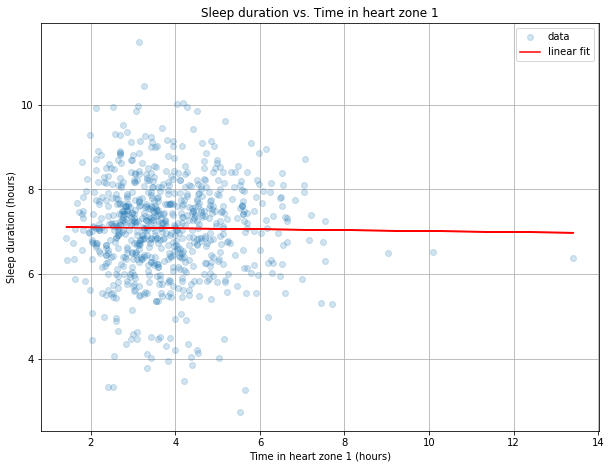

R-squared: 0.0011543883558752185 for Sleep duration vs. Time in heart zone 2


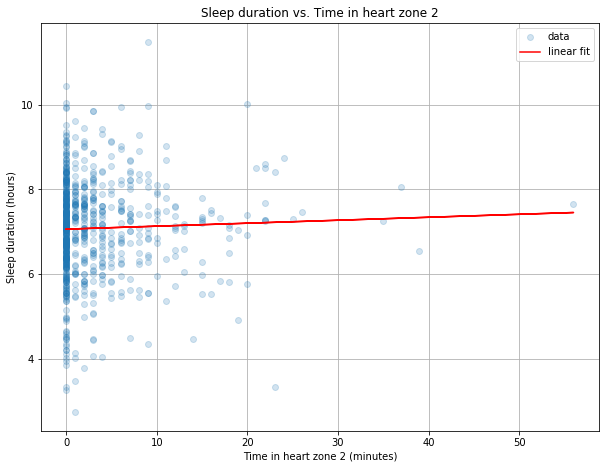

R-squared: 0.006723149814046829 for Sleep duration vs. Time in heart zone 3


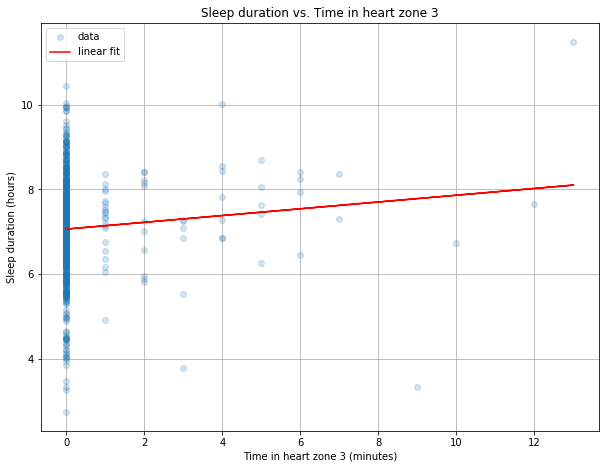

In [17]:
plot_nice(heart_below_one_list,sleep_list,"Sleep duration vs. Time below heart zone 1","Time below heart zone 1 (hours)","Sleep duration (hours)")
plot_nice(heart_zone_one_list,sleep_list,"Sleep duration vs. Time in heart zone 1","Time in heart zone 1 (hours)","Sleep duration (hours)")
plot_nice(heart_zone_two_list,sleep_list,"Sleep duration vs. Time in heart zone 2","Time in heart zone 2 (minutes)","Sleep duration (hours)")
plot_nice(heart_zone_three_list,sleep_list,"Sleep duration vs. Time in heart zone 3","Time in heart zone 3 (minutes)","Sleep duration (hours)")

R-squared: 7.025191254031072e-08 for Sleep duration vs. Lightly active time


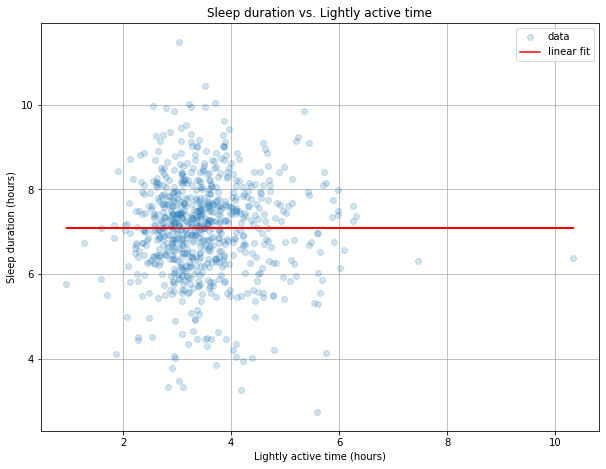

R-squared: 0.0008689711876191451 for Sleep duration vs. Moderately active time


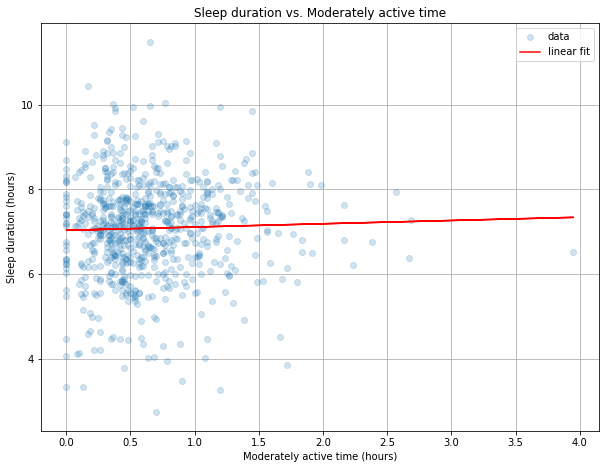

R-squared: 0.0023592134193265958 for Sleep duration vs. Very active time


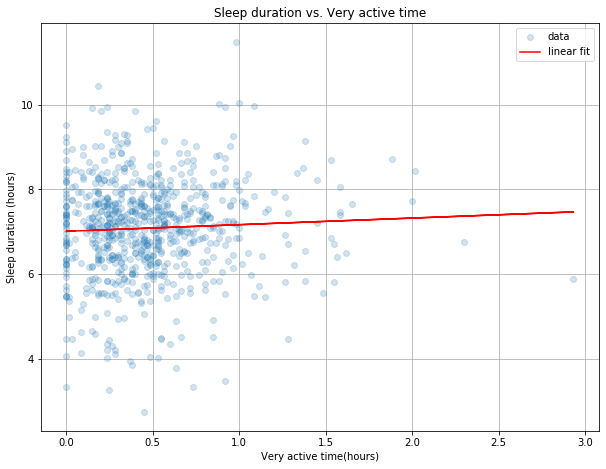

R-squared: 0.001821607429065802 for Sleep duration vs. Sedentary time


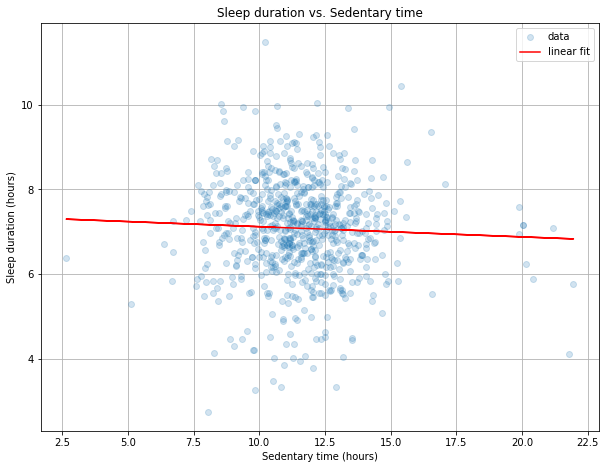

In [18]:
plot_nice(lightly_active_list,sleep_list,"Sleep duration vs. Lightly active time","Lightly active time (hours)","Sleep duration (hours)")
plot_nice(moderately_active_list,sleep_list,"Sleep duration vs. Moderately active time","Moderately active time (hours)","Sleep duration (hours)")
plot_nice(very_active_list,sleep_list,"Sleep duration vs. Very active time","Very active time(hours)","Sleep duration (hours)")
plot_nice(sedentary_list,sleep_list,"Sleep duration vs. Sedentary time","Sedentary time (hours)","Sleep duration (hours)")

R-squared: 0.00045842206330364726 for Sleep duration vs. Floors


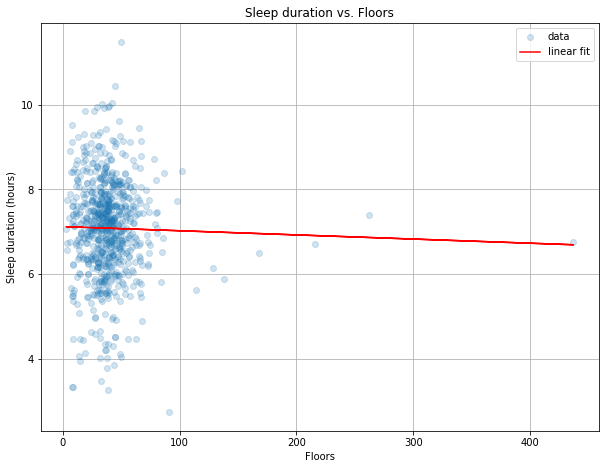

R-squared: 0.0008779971773774244 for Sleep duration vs. Distance


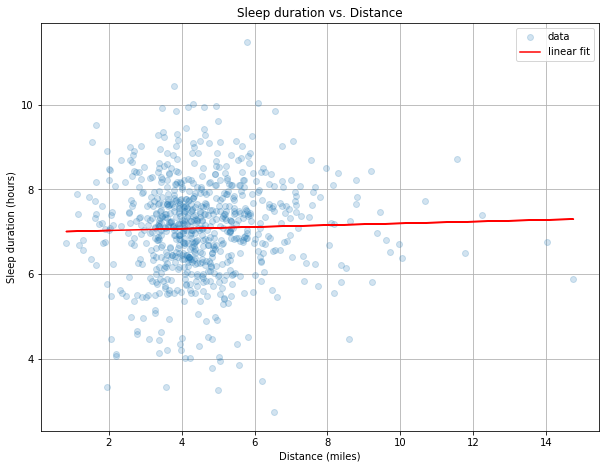

R-squared: 0.0007393413578413962 for Sleep duration vs. Calories


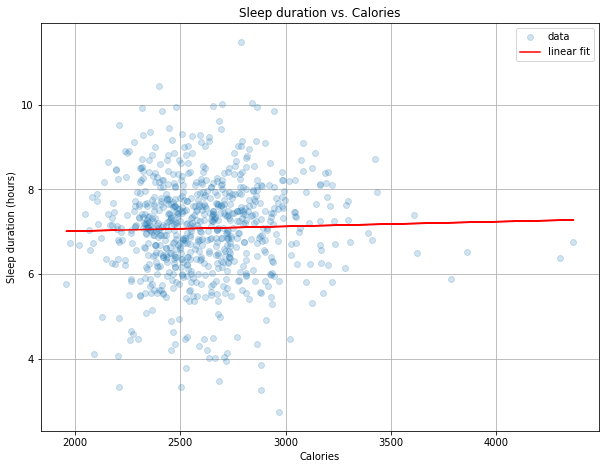

R-squared: 0.0008609883968706821 for Sleep duration vs. Steps


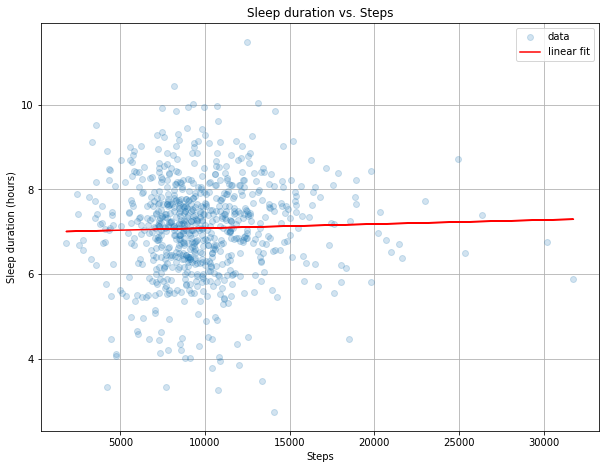

In [19]:
plot_nice(stairs_list,sleep_list,"Sleep duration vs. Floors","Floors","Sleep duration (hours)")
plot_nice(distance_list,sleep_list,"Sleep duration vs. Distance","Distance (miles)","Sleep duration (hours)")
plot_nice(calories_list,sleep_list,"Sleep duration vs. Calories","Calories","Sleep duration (hours)")
plot_nice(steps_list,sleep_list,"Sleep duration vs. Steps","Steps","Sleep duration (hours)")

R-squared: 0.005829364654329393 for Sleep duration vs. Max temperature


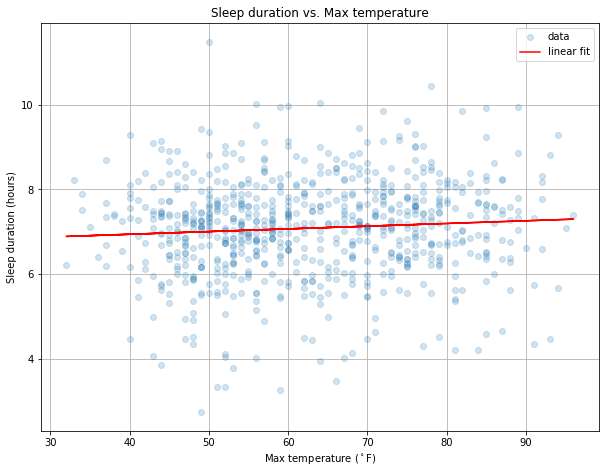

R-squared: 0.010364346814989397 for Sleep duration vs. Min temperature


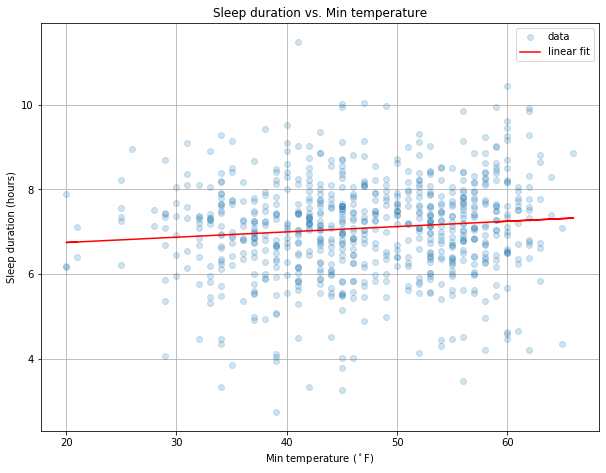

In [20]:
plot_nice(temp_max_list,sleep_list,"Sleep duration vs. Max temperature","Max temperature ($^\circ$F)","Sleep duration (hours)")
plot_nice(temp_min_list,sleep_list,"Sleep duration vs. Min temperature","Min temperature ($^\circ$F)","Sleep duration (hours)")

R-squared: 0.0008834841123750698 for Sleep duration vs. Previous day's sleep


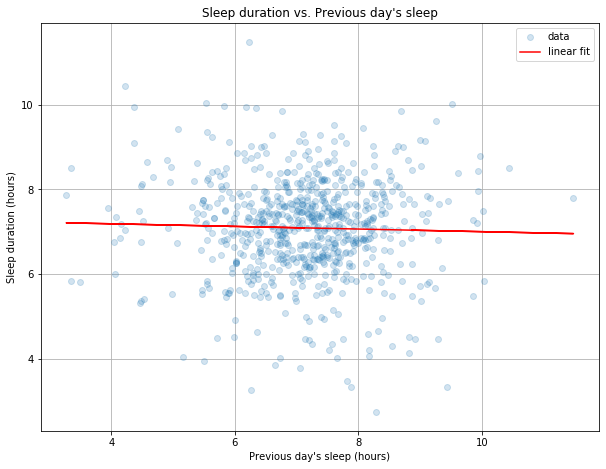

R-squared: 0.14514371924029681 for Sleep duration vs. Start time


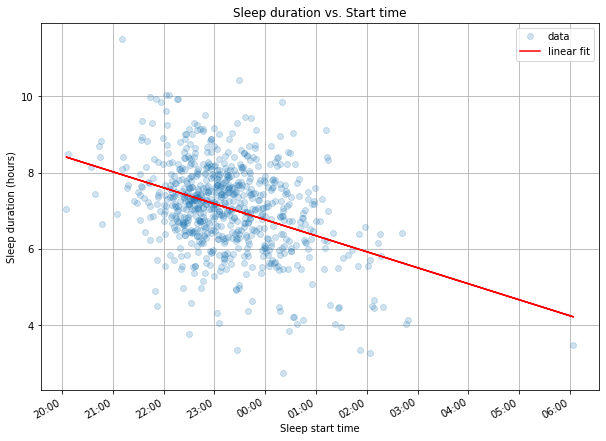

R-squared: 0.3427814204521534 for Sleep duration vs. Stop time


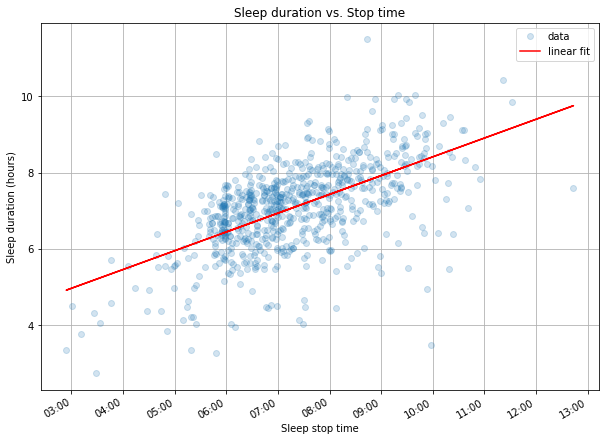

In [21]:
plot_nice(previous_day_sleep_list,current_day_sleep_list,"Sleep duration vs. Previous day's sleep","Previous day's sleep (hours)","Sleep duration (hours)")
plot_nice(start_time_list,sleep_list,"Sleep duration vs. Start time","Sleep start time","Sleep duration (hours)")
plot_nice(stop_time_list,sleep_list,"Sleep duration vs. Stop time","Sleep stop time","Sleep duration (hours)")

### References 
Ref #1 = https://stackoverflow.com/questions/1574088/plotting-time-in-python-with-matplotlib/16428019#16428019

Ref #2 = https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/bar_stacked.html#sphx-glr-gallery-lines-bars-and-markers-bar-stacked-py
